**Hammad Latif**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Downloading Dataset

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
(train_data, test_data), ds_info = tfds.load(name="food101", split=["train", "validation"], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Food101 Classes
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Write all class names to the file
with open("Food101_classes.txt", "w") as file:
    for name in class_names:
        file.write(name + "\n")

In [ ]:
for image, label in train_data.take(1):
  print(f"""
        Shape of Image: {image.shape}
        Type of Image: {image.dtype}
        Label : {label.numpy()}
         """)


        Shape of Image: (306, 512, 3)
        Type of Image: <dtype: 'uint8'>
        Label : 29
         


In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 48,  51,  30],
        [ 49,  52,  31],
        [ 50,  55,  33],
        ...,
        [ 93, 120,  77],
        [ 87, 112,  70],
        [ 80, 105,  63]],

       [[ 43,  46,  25],
        [ 46,  49,  28],
        [ 49,  54,  32],
        ...,
        [ 95, 122,  77],
        [ 90, 117,  72],
        [ 83, 110,  65]],

       [[ 40,  43,  22],
        [ 45,  48,  27],
        [ 50,  55,  33],
        ...,
        [ 90, 119,  71],
        [ 87, 116,  68],
        [ 84, 113,  65]],

       ...,

       [[ 48,  55,  37],
        [ 48,  55,  37],
        [ 41,  50,  33],
        ...,
        [ 32,  43,  35],
        [ 25,  36,  30],
        [ 21,  32,  26]],

       [[ 42,  47,  27],
        [ 38,  46,  25],
        [ 34,  43,  26],
        ...,
        [ 38,  49,  41],
        [ 33,  44,  38],
        [ 29,  40,  34]],

       [[ 37,  42,  20],
        [ 32,  40,  19],
        [ 31,  38,  20],
        ...,
        [ 33,  44,  3

# Becoming One With the Data

In [4]:
import matplotlib.pyplot as plt


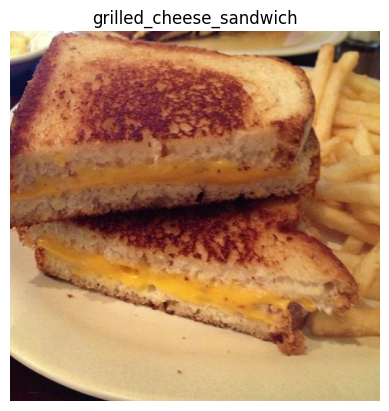

In [ ]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

# Data Preprocessing

In [ ]:
# Resize images and create Batches
IMG_SIZE=(224,224)
BATCH_SIZE=32

def preprocess_img(image, label, img_size=IMG_SIZE):
  image = tf.image.resize(image, img_size)
  return tf.cast(image, tf.float32), label   #convert image dtype to float32


In [ ]:
train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
len(train_data)

2367

In [ ]:
2367*32

75744

# Build the Model

I am using **EfficientNetB7** as Base Model



In [ ]:
# create ModelCheckpoint
checkpoint_path = "Chrome_model_feature_extractor_checkpoints.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      )

In [ ]:
# Use fixed precision to lessen the computational time
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = tf.keras.layers.Dense(101)(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb7 (Functional)          │ (None, 7, 7, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         258,661 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,356,348 (245.50 MB)

 Trainable params: 258,661 (1010.39 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [ ]:
for layer in model.layers:
  print(f"{layer.name} | {layer.trainable} | {layer.dtype} | {layer.dtype_policy}")

input_layer | True | float32 | <DTypePolicy "float32">
efficientnetb7 | False | float32 | <DTypePolicy "float32">
global_average_pooling_layer | True | float32 | <DTypePolicy "float32">
dense | True | float32 | <DTypePolicy "float32">
softmax_float32 | True | float32 | <DTypePolicy "float32">


In [ ]:
for layer in model.layers[1].layers:
  print(f"{layer.name} | {layer.trainable} | {layer.dtype} | {layer.dtype_policy}")

input_layer | False | float32 | <DTypePolicy "float32">
rescaling | False | float32 | <DTypePolicy "float32">
normalization | False | float32 | <DTypePolicy "float32">
rescaling_1 | False | float32 | <DTypePolicy "float32">
stem_conv_pad | False | float32 | <DTypePolicy "float32">
stem_conv | False | float32 | <DTypePolicy "float32">
stem_bn | False | float32 | <DTypePolicy "float32">
stem_activation | False | float32 | <DTypePolicy "float32">
block1a_dwconv | False | float32 | <DTypePolicy "float32">
block1a_bn | False | float32 | <DTypePolicy "float32">
block1a_activation | False | float32 | <DTypePolicy "float32">
block1a_se_squeeze | False | float32 | <DTypePolicy "float32">
block1a_se_reshape | False | float32 | <DTypePolicy "float32">
block1a_se_reduce | False | float32 | <DTypePolicy "float32">
block1a_se_expand | False | float32 | <DTypePolicy "float32">
block1a_se_excite | False | float32 | <DTypePolicy "float32">
block1a_project_conv | False | float32 | <DTypePolicy "float32"

In [ ]:
initial_epochs = 7
history = model.fit(train_data,
                    epochs = initial_epochs,
                    validation_data = test_data,
                    validation_steps = int(0.15 * len(test_data)),
                    callbacks = [model_checkpoint])

Epoch 1/7
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 406s 136ms/step - accuracy: 0.4333 - loss: 2.3998 - val_accuracy: 0.6266 - val_loss: 1.3996
Epoch 2/7
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 299s 125ms/step - accuracy: 0.6041 - loss: 1.5479 - val_accuracy: 0.6703 - val_loss: 1.2557
Epoch 3/7
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 305s 128ms/step - accuracy: 0.6373 - loss: 1.3893 - val_accuracy: 0.6729 - val_loss: 1.2213
Epoch 4/7
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 305s 128ms/step - accuracy: 0.6684 - loss: 1.2677 - val_accuracy: 0.6735 - val_loss: 1.2220
Epoch 5/7
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 309s 130ms/step - accuracy: 0.6850 - loss: 1.1929 - val_accuracy: 0.6785 - val_loss: 1.1888
Epoch 6/7
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 315s 126ms/step - accuracy: 0.6974 - loss: 1.1398 - val_accuracy: 0.6772 - val_loss: 1.2334
Epoch 7/7
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 297s 124ms/step - accuracy: 0.7167 - loss: 1.0762 - val_accuracy: 0.6813 - val_loss: 1.2356


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

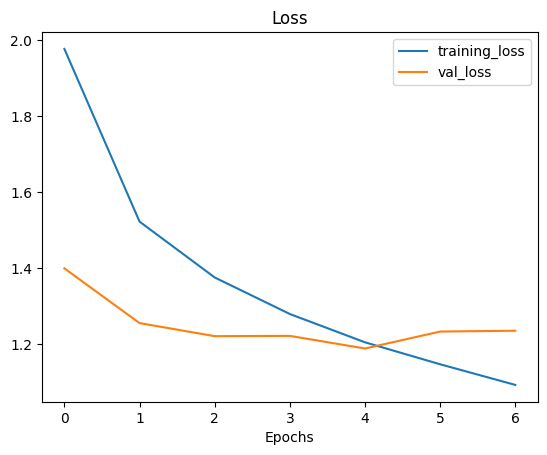

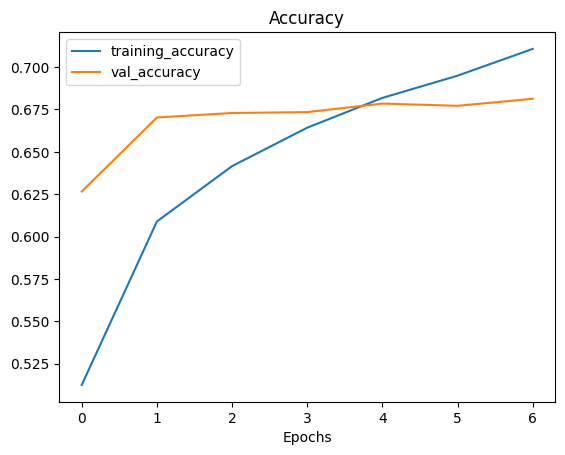

In [ ]:
plot_loss_curves(history)

**Model Evaluation on Test data**

In [ ]:
loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss} | Test Accuracy: {accuracy}")

789/789 ━━━━━━━━━━━━━━━━━━━━ 117s 110ms/step - accuracy: 0.6784 - loss: 1.2016
Test Loss: 1.2042924165725708 | Test Accuracy: 0.6775586009025574


# Fine-Tuning the EfficeincetNetB7 Model


In [ ]:
model.load_weights("/content/drive/MyDrive/Fine_tunned_modelB7_checkpoints_epoch_34.weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 1428 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1424 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
Base_model = model.layers[1]
Base_model.trainable = True

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb7 (Functional)          │ (None, 7, 7, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         258,661 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,356,348 (245.50 MB)

 Trainable params: 64,045,621 (244.31 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics = ["accuracy"])

In [ ]:
# create ModelCheckpoint
checkpoint_path = "/content/drive/My Drive/Fine_tunned_modelB7_checkpoints_epoch_{epoch:02d}.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=False,
                                                      save_weights_only=True,
                                                      )

In [ ]:
fine_tune_epoch = 5 + 4
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 4,
                              validation_steps = int(0.15 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 5/9
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 2499s 934ms/step - accuracy: 0.5935 - loss: 1.6146 - val_accuracy: 0.8260 - val_loss: 0.6218
Epoch 6/9
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 2205s 930ms/step - accuracy: 0.8692 - loss: 0.4755 - val_accuracy: 0.8197 - val_loss: 0.6658
Epoch 7/9
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 2243s 931ms/step - accuracy: 0.9502 - loss: 0.1707 - val_accuracy: 0.8231 - val_loss: 0.7361
Epoch 8/9
 908/2367 ━━━━━━━━━━━━━━━━━━━━ 22:09 911ms/step - accuracy: 0.9662 - loss: 0.1125

In [ ]:
model.evaluate(test_data)

789/789 ━━━━━━━━━━━━━━━━━━━━ 116s 108ms/step - accuracy: 0.8160 - loss: 0.7418


[0.7529486417770386, 0.8148368000984192]

In [ ]:
fine_tune_epoch = 10
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 7,
                              validation_steps = int(0.20 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 8/10
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1454s 480ms/step - accuracy: 0.9581 - loss: 0.1312 - val_accuracy: 0.8264 - val_loss: 0.7570
Epoch 9/10
 858/2367 ━━━━━━━━━━━━━━━━━━━━ 11:29 457ms/step - accuracy: 0.9742 - loss: 0.0823

In [ ]:
fine_tune_epoch = 13
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 8,
                              validation_steps = int(0.20 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 9/13
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1485s 487ms/step - accuracy: 0.9694 - loss: 0.0960 - val_accuracy: 0.8157 - val_loss: 0.8101
Epoch 10/13
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1190s 484ms/step - accuracy: 0.9785 - loss: 0.0711 - val_accuracy: 0.8244 - val_loss: 0.8202
Epoch 11/13
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1169s 493ms/step - accuracy: 0.9788 - loss: 0.0671 - val_accuracy: 0.8191 - val_loss: 0.8834
Epoch 12/13
1791/2367 ━━━━━━━━━━━━━━━━━━━━ 4:28 465ms/step - accuracy: 0.9822 - loss: 0.0541

In [ ]:
fine_tune_epoch = 15
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 11,
                              validation_steps = int(0.20 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 12/15
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1560s 501ms/step - accuracy: 0.9799 - loss: 0.0615 - val_accuracy: 0.8264 - val_loss: 0.8589
Epoch 13/15
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1189s 501ms/step - accuracy: 0.9825 - loss: 0.0532 - val_accuracy: 0.8189 - val_loss: 0.9468
Epoch 14/15
 536/2367 ━━━━━━━━━━━━━━━━━━━━ 14:20 470ms/step - accuracy: 0.9823 - loss: 0.0591

In [ ]:
fine_tune_epoch = 20
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 13,
                              validation_steps = int(0.25 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 14/20
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1492s 492ms/step - accuracy: 0.9820 - loss: 0.0559 - val_accuracy: 0.8341 - val_loss: 0.8553
Epoch 15/20
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1188s 501ms/step - accuracy: 0.9859 - loss: 0.0467 - val_accuracy: 0.8215 - val_loss: 0.9549
Epoch 16/20
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1240s 522ms/step - accuracy: 0.9858 - loss: 0.0442 - val_accuracy: 0.8290 - val_loss: 0.8808
Epoch 17/20
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1321s 557ms/step - accuracy: 0.9877 - loss: 0.0403 - val_accuracy: 0.8255 - val_loss: 0.9201
Epoch 18/20
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9880 - loss: 0.0374

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1441s 607ms/step - accuracy: 0.9880 - loss: 0.0374 - val_accuracy: 0.8125 - val_loss: 0.6693
Epoch 19/20
 266/2367 ━━━━━━━━━━━━━━━━━━━━ 2:17:55 4s/step - accuracy: 0.9848 - loss: 0.0433

In [ ]:
fine_tune_epoch = 25
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 18,
                              validation_steps = int(0.30 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 19/25
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1497s 494ms/step - accuracy: 0.9871 - loss: 0.0389 - val_accuracy: 0.8273 - val_loss: 0.9554
Epoch 20/25
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1175s 495ms/step - accuracy: 0.9886 - loss: 0.0341 - val_accuracy: 0.8280 - val_loss: 0.9835
Epoch 21/25
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1211s 510ms/step - accuracy: 0.9890 - loss: 0.0357 - val_accuracy: 0.8280 - val_loss: 0.9440
Epoch 22/25
1817/2367 ━━━━━━━━━━━━━━━━━━━━ 4:18 470ms/step - accuracy: 0.9899 - loss: 0.0312

In [ ]:
fine_tune_epoch = 25
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 21,
                              validation_steps = int(0.30 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 22/25
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1535s 497ms/step - accuracy: 0.9888 - loss: 0.0344 - val_accuracy: 0.8365 - val_loss: 0.9290
Epoch 23/25
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1195s 500ms/step - accuracy: 0.9894 - loss: 0.0343 - val_accuracy: 0.8264 - val_loss: 0.9771
Epoch 24/25
  91/2367 ━━━━━━━━━━━━━━━━━━━━ 17:49 470ms/step - accuracy: 0.9903 - loss: 0.0229

In [ ]:
fine_tune_epoch = 30
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 23,
                              validation_steps = int(0.30 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 24/30
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1484s 478ms/step - accuracy: 0.9903 - loss: 0.0302 - val_accuracy: 0.8272 - val_loss: 0.9905
Epoch 25/30
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1158s 488ms/step - accuracy: 0.9915 - loss: 0.0281 - val_accuracy: 0.8263 - val_loss: 1.0071
Epoch 26/30
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1200s 505ms/step - accuracy: 0.9916 - loss: 0.0270 - val_accuracy: 0.8261 - val_loss: 1.0089
Epoch 27/30
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9910 - loss: 0.0275

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1224s 516ms/step - accuracy: 0.9910 - loss: 0.0275 - val_accuracy: 0.8221 - val_loss: 1.0023
Epoch 28/30
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1286s 542ms/step - accuracy: 0.9911 - loss: 0.0283 - val_accuracy: 0.8215 - val_loss: 1.0560
Epoch 29/30
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1626s 669ms/step - accuracy: 0.9911 - loss: 0.0286 - val_accuracy: 0.8236 - val_loss: 1.0398
Epoch 30/30


In [ ]:
fine_tune_epoch = 35
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 29,
                              validation_steps = int(0.30 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 30/35
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1521s 491ms/step - accuracy: 0.9917 - loss: 0.0255 - val_accuracy: 0.8332 - val_loss: 0.9979
Epoch 31/35
1969/2367 ━━━━━━━━━━━━━━━━━━━━ 3:09 476ms/step - accuracy: 0.9924 - loss: 0.0241

In [ ]:
fine_tune_epoch = 36
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 30,
                              validation_steps = int(0.30 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 31/36
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1541s 496ms/step - accuracy: 0.9910 - loss: 0.0271 - val_accuracy: 0.8300 - val_loss: 1.0323
Epoch 32/36
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1207s 499ms/step - accuracy: 0.9919 - loss: 0.0262 - val_accuracy: 0.8277 - val_loss: 1.0272
Epoch 33/36
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1220s 514ms/step - accuracy: 0.9927 - loss: 0.0225 - val_accuracy: 0.8366 - val_loss: 0.9790
Epoch 34/36
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9919 - loss: 0.0251

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1287s 542ms/step - accuracy: 0.9919 - loss: 0.0251 - val_accuracy: 0.8422 - val_loss: 0.9410
Epoch 35/36
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1340s 565ms/step - accuracy: 0.9932 - loss: 0.0221 - val_accuracy: 0.8277 - val_loss: 1.0158
Epoch 36/36
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1433s 604ms/step - accuracy: 0.9931 - loss: 0.0215 - val_accuracy: 0.8252 - val_loss: 1.0925


In [ ]:
fine_tune_epoch = 40
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 35,
                              validation_steps = int(0.30 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 36/40
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1529s 494ms/step - accuracy: 0.9929 - loss: 0.0217 - val_accuracy: 0.8318 - val_loss: 1.0057
Epoch 37/40
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1212s 500ms/step - accuracy: 0.9935 - loss: 0.0204 - val_accuracy: 0.8308 - val_loss: 1.0629
Epoch 38/40
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1206s 508ms/step - accuracy: 0.9928 - loss: 0.0220 - val_accuracy: 0.8288 - val_loss: 1.0155
Epoch 39/40
2047/2367 ━━━━━━━━━━━━━━━━━━━━ 2:32 477ms/step - accuracy: 0.9937 - loss: 0.0199

In [ ]:
fine_tune_epoch = 45
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 38,
                              validation_steps = int(0.30 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 39/45
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1566s 508ms/step - accuracy: 0.9929 - loss: 0.0213 - val_accuracy: 0.8326 - val_loss: 1.0153
Epoch 40/45
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1270s 514ms/step - accuracy: 0.9938 - loss: 0.0183 - val_accuracy: 0.8195 - val_loss: 1.1338
Epoch 41/45
1616/2367 ━━━━━━━━━━━━━━━━━━━━ 6:03 484ms/step - accuracy: 0.9943 - loss: 0.0171

KeyboardInterrupt: 

In [ ]:
fine_tune_epoch = 46
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 40,
                              validation_steps = int(0.30 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 41/46
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1503s 493ms/step - accuracy: 0.9933 - loss: 0.0212 - val_accuracy: 0.8314 - val_loss: 1.0415
Epoch 42/46
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1191s 502ms/step - accuracy: 0.9942 - loss: 0.0184 - val_accuracy: 0.8284 - val_loss: 1.0723
Epoch 43/46
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1241s 523ms/step - accuracy: 0.9939 - loss: 0.0194 - val_accuracy: 0.8288 - val_loss: 1.0645
Epoch 44/46
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9940 - loss: 0.0182

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1414s 596ms/step - accuracy: 0.9940 - loss: 0.0182 - val_accuracy: 0.8275 - val_loss: 1.0372
Epoch 45/46
  70/2367 ━━━━━━━━━━━━━━━━━━━━ 33:00:02 52s/step - accuracy: 0.9951 - loss: 0.0134

In [ ]:
fine_tune_epoch = 50
history_fine_tune = model.fit(train_data,
                              epochs = fine_tune_epoch,
                              validation_data = test_data,
                              initial_epoch = 44,
                              validation_steps = int(0.30 * len(test_data)),
                              callbacks = [model_checkpoint]
                              )

Epoch 45/50
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1526s 498ms/step - accuracy: 0.9940 - loss: 0.0204 - val_accuracy: 0.8306 - val_loss: 1.0624
Epoch 46/50
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1169s 493ms/step - accuracy: 0.9945 - loss: 0.0176 - val_accuracy: 0.8337 - val_loss: 1.0996
Epoch 47/50
2367/2367 ━━━━━━━━━━━━━━━━━━━━ 1236s 521ms/step - accuracy: 0.9942 - loss: 0.0172 - val_accuracy: 0.8223 - val_loss: 1.1007
Epoch 48/50
1368/2367 ━━━━━━━━━━━━━━━━━━━━ 7:52 473ms/step - accuracy: 0.9948 - loss: 0.0170

In [ ]:
loss, accuracy = model.evaluate(test_data)

789/789 ━━━━━━━━━━━━━━━━━━━━ 137s 124ms/step - accuracy: 0.8335 - loss: 0.9896


# Model Evaluation Before and After Fine Tuning

In [6]:
history = {
    'accuracy': [0.4333, 0.6041, 0.6373, 0.6684, 0.6850, 0.6974, 0.7167],
    'loss': [2.3998, 1.5479, 1.3893, 1.2677, 1.1929, 1.1398, 1.0762],
    'val_accuracy': [0.6266, 0.6703, 0.6729, 0.6735, 0.6785, 0.6772, 0.6813],
    'val_loss': [1.3996, 1.2557, 1.2213, 1.2220, 1.1888, 1.2334, 1.2356]
}


In [7]:
history_fine_tuned = {
    'accuracy': [
        0.5935, 0.8692, 0.9502, 0.9581, 0.9694, 0.9785, 0.9788, 0.9799, 0.9825,
        0.9820, 0.9859, 0.9858, 0.9877, 0.9880, 0.9871, 0.9886, 0.9890, 0.9888,
        0.9894, 0.9903, 0.9915, 0.9916, 0.9910, 0.9911, 0.9911, 0.9917, 0.9910,
        0.9919, 0.9927, 0.9919, 0.9932, 0.9931, 0.9929, 0.9935, 0.9928, 0.9929,
        0.9938, 0.9933, 0.9942, 0.9939, 0.9940, 0.9940, 0.9945, 0.9942
    ],
    'loss': [
        1.6146, 0.4755, 0.1707, 0.1312, 0.0960, 0.0711, 0.0671, 0.0615, 0.0532,
        0.0559, 0.0467, 0.0442, 0.0403, 0.0374, 0.0389, 0.0341, 0.0357, 0.0344,
        0.0343, 0.0302, 0.0281, 0.0270, 0.0275, 0.0283, 0.0286, 0.0255, 0.0271,
        0.0262, 0.0225, 0.0251, 0.0221, 0.0215, 0.0217, 0.0204, 0.0220, 0.0213,
        0.0183, 0.0212, 0.0184, 0.0194, 0.0182, 0.0204, 0.0176, 0.0172
    ],
    'val_accuracy': [
        0.8260, 0.8197, 0.8231, 0.8264, 0.8157, 0.8244, 0.8191, 0.8264, 0.8189,
        0.8341, 0.8215, 0.8290, 0.8255, 0.8125, 0.8273, 0.8280, 0.8280, 0.8365,
        0.8264, 0.8272, 0.8263, 0.8261, 0.8221, 0.8215, 0.8236, 0.8332, 0.8300,
        0.8277, 0.8366, 0.8422, 0.8277, 0.8252, 0.8318, 0.8308, 0.8288, 0.8326,
        0.8195, 0.8314, 0.8284, 0.8288, 0.8275, 0.8306, 0.8337, 0.8223
    ],
    'val_loss': [
        0.6218, 0.6658, 0.7361, 0.7570, 0.8101, 0.8202, 0.8834, 0.8589, 0.9468,
        0.8553, 0.9549, 0.8808, 0.9201, 0.6693, 0.9554, 0.9835, 0.9440, 0.9290,
        0.9771, 0.9905, 1.0071, 1.0089, 1.0023, 1.0560, 1.0398, 0.9979, 1.0323,
        1.0272, 0.9790, 0.9410, 1.0158, 1.0925, 1.0057, 1.0629, 1.0155, 1.0153,
        1.1338, 1.0415, 1.0723, 1.0645, 1.0372, 1.0624, 1.0996, 1.1007
    ]
}


In [9]:
def compare_historys(original_history, new_history, initial_epochs=5):
  """
    Compares two model history objects.
    """

  # Get original history measurements
  acc = original_history['accuracy']
  val_acc = original_history['val_accuracy']
  loss = original_history['loss']
  val_loss = original_history['val_loss']

  # Combine original history with new history
  total_acc = acc + new_history['accuracy']
  total_val_acc = val_acc + new_history['val_accuracy']
  total_loss = loss + new_history['loss']
  total_val_loss = val_loss + new_history['val_loss']

  # make plots
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title("Training and Validation Accuracy")

  plt.subplot(2, 1,2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


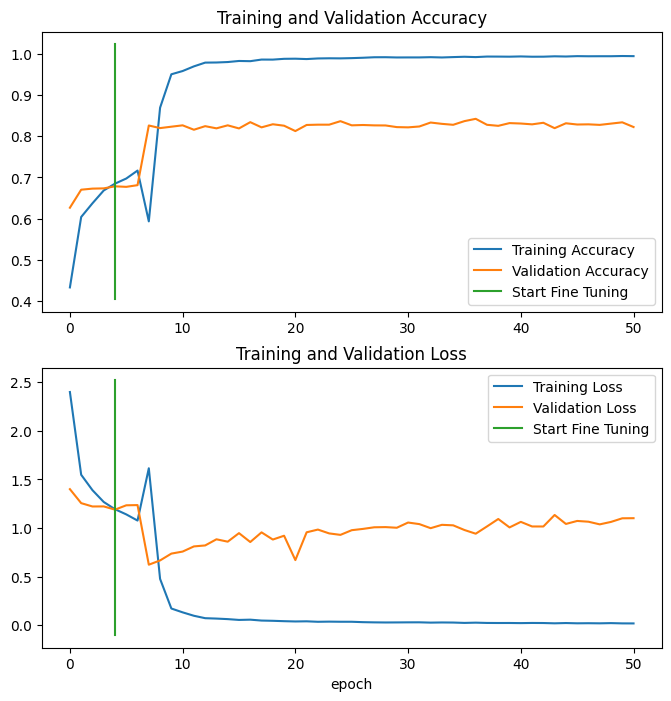

In [10]:
compare_historys(history,history_fine_tuned)

**Insights**

1. `Training Phase (Frozen Layers):` The model improved steadily, with training accuracy reaching ~71.6% and validation accuracy ~68.1%. Losses decreased, but validation metrics plateaued toward the end.

2. `Fine-Tuning Phase:` Training accuracy rose to over 99%, and loss dropped significantly, but validation accuracy only improved slightly (~82%-84%). Validation loss increased, indicating overfitting during fine-tuning.

3. `Key Issue:` Overfitting is evident as the model performs exceptionally on training data but struggles to generalize further to validation data.

4. `Recommendation:` Use regularization (e.g., dropout, L2), reduce learning rate, or unfreeze fewer layers during fine-tuning to improve generalization.

**Reasons why i am not addressing this Overfitting**

  1. `Time Constraints:` Each epoch takes approximately 22 minutes to complete, making additional training extremely time-consuming. The fine-tuning process already took nearly a week to complete.

  2. `Resource Limitations:` Due to limited GPU access on Colab, it was challenging to speed up training or experiment with additional techniques.

  3. `Unpredictable Interruptions:` Electricity and WiFi outages occasionally disrupted the training process, further adding to the challenge of retraining or fine-tuning.

  4. `Project Deadline:` The project deadline has already passed, and further training would not fit within the given timeline.

  5. `Performance on Custom Data:` Despite the overfitting observed in validation metrics, the model performs well on custom data, correctly predicting food items, which meets the project's practical objectives.

These challenges made it impractical to continue addressing overfitting, but the current model achieves its primary goal effectively.